torch.Size([2, 28, 28])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             816
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]          12,832
       BatchNorm2d-6           [-1, 32, 14, 14]              64
              ReLU-7           [-1, 32, 14, 14]               0
         MaxPool2d-8             [-1, 32, 7, 7]               0
            Linear-9                    [-1, 2]           3,138
Total params: 16,882
Trainable params: 16,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.47
Params size (MB): 0.06
Estimated Total Size (MB): 0.54
---------------------

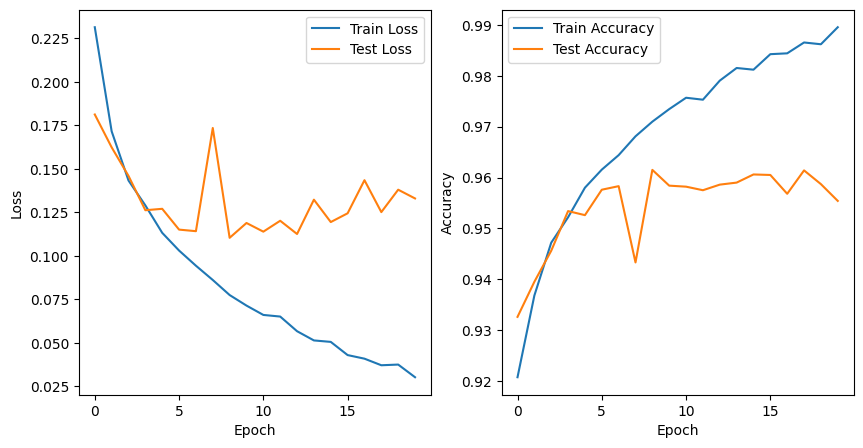

In [9]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchsummary import summary

# MNIST 数据集
mnist_train = dsets.MNIST(root='./data',
                           train=True, 
                           transform=transforms.ToTensor(),
                           download=True)

mnist_test = dsets.MNIST(root='./data',
                          train=False, 
                          transform=transforms.ToTensor())

# 生成新的训练集和测试集
def create_new_dataset(mnist_dataset):
    new_data = []
    new_labels = []
    for i in range(len(mnist_dataset)):
        # 随机选择两张图片
        idx1, idx2 = np.random.choice(len(mnist_dataset), 2)
        img1, label1 = mnist_dataset[idx1]
        img2, label2 = mnist_dataset[idx2]
        
        # 移除大小为1的维度
        img1 = torch.squeeze(img1)
        img2 = torch.squeeze(img2)
        
        # 将两张图片拼接在一起
        new_img = torch.stack([img1, img2], dim=0)  # 修改在这里
        
        # 分配标签
        new_label = 1 if label1 == label2 else 0
        
        new_data.append(new_img)
        new_labels.append(new_label)
    
    return new_data, new_labels

new_train_data, new_train_labels = create_new_dataset(mnist_train)
new_test_data, new_test_labels = create_new_dataset(mnist_test)
print(new_train_data[0].shape)



# 超参数
num_epochs = 20
batch_size = 100
learning_rate = 0.001

# 数据加载器
train_loader = torch.utils.data.DataLoader(dataset=list(zip(new_train_data, new_train_labels)),
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=list(zip(new_test_data, new_test_labels)),
                                          batch_size=batch_size, 
                                          shuffle=False)

# 卷积神经网络模型
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

cnn = ConvNet()

summary(cnn,(2,28,28))

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# 记录每一轮训练的损失和准确率
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# 训练模型
for epoch in range(num_epochs):
    train_loss = 0
    train_correct = 0
    test_loss = 0
    test_correct = 0
    
    cnn.train()
    # 训练阶段
    for images, labels in train_loader:
        images = Variable(images)
        labels = Variable(labels)
        
        # 前向 + 后向 + 优化
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
    
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(train_correct / len(train_loader.dataset))
    
    cnn.eval()
    # 测试阶段
    with torch.no_grad():
        for images, labels in test_loader:
            images = Variable(images)
            labels = Variable(labels)
            
            outputs = cnn(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
    
    test_losses.append(test_loss / len(test_loader))
    test_accs.append(test_correct / len(test_loader.dataset))
    
    print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
          .format(epoch+1, train_losses[-1], train_accs[-1], test_losses[-1], test_accs[-1]))


# 绘制损失图像
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制准确率图像
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()